# 2- Pneumothorax segmentation with UNet and Fastai

The second part of our project consists of doing segmentation of pneumothorax using UNet network and Fastai in order to help non specialist medical doctors diagnose the disease.

Pneumothorax : (From Wikipedia)

> 


A pneumothorax is an abnormal collection of air in the pleural space between the lung and the chest wall. Symptoms typically include sudden onset of sharp, one-sided chest pain and shortness of breath.



The following image is taken from Wikipedia

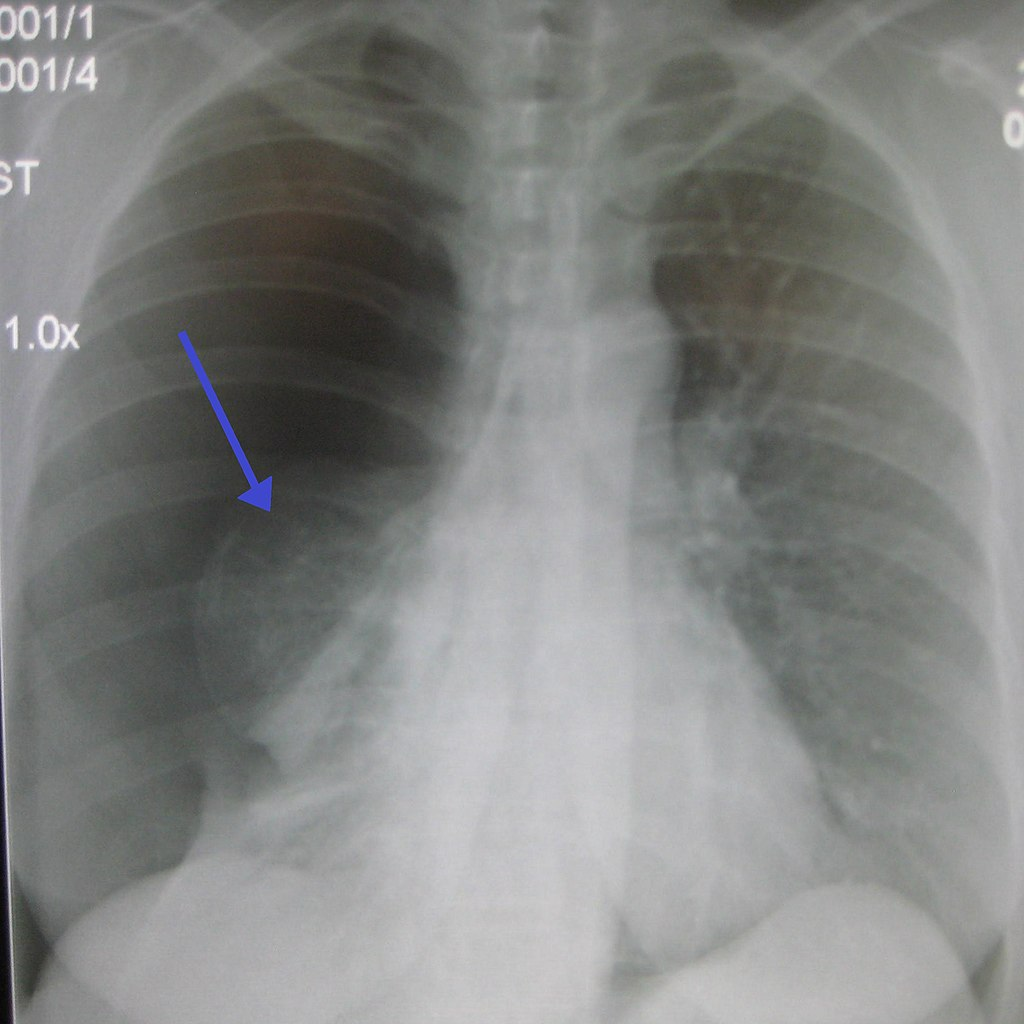

Please download dataset from the following link: https://www.kaggle.com/mnpinto/pneumotorax256

# Data collection

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"sammdl8","key":"afd3cb05f9bd1d4f18a4ab2330c37714"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json  ~/.kaggle/

#change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mnpinto/pneumotorax256

pneumotorax256.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
file_name= 'pneumotorax256.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
from fastai.vision import *

In [ ]:
path=Path('/content/data256/masks')

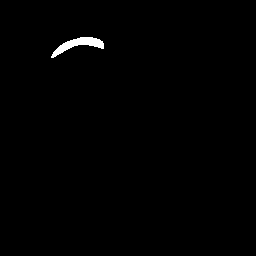

In [ ]:
img=open_image('/content/data256/masks/1.2.276.0.7230010.3.1.4.8323329.10005.1517875220.958951.png')
img

the white stain in the above image means there is air leak. Our goal is to predict the placement of air leak.
The following function will be used to normalize data.

In [ ]:
def my_open(self,fn):
  return open_mask(fn,after_open=self.after_open,div=True)

SegmentationLabelList.open=my_open

Note that every image in the training set (train folder) has its own mask in the masks' folder. So the next step is to train our segmentation model. 
Our model classes are black (0=0/255) and white (1=255/255). In fact the white color indicates the presence of air and black color indicates the absence of air (normal case).

In [ ]:
data= (SegmentationItemList.from_folder(path='/content/data256/train') #the files
      .split_by_rand_pct(0.2) #20% random split of train and test set
      .label_from_func(lambda x:str(x).replace('train','masks'),classes=[0,1]) #every image in "train" folder has its mask in "mask" folder. classes =[0,1] because we normalized the images
      .transform(get_transforms(),size=256,tfm_y=True) #tfm_y=true because when image is transformed the label(mask) is transformed. exp: rotation
      .databunch(path=Path('.'),bs=32) #batch size
      .normalize(imagenet_stats))

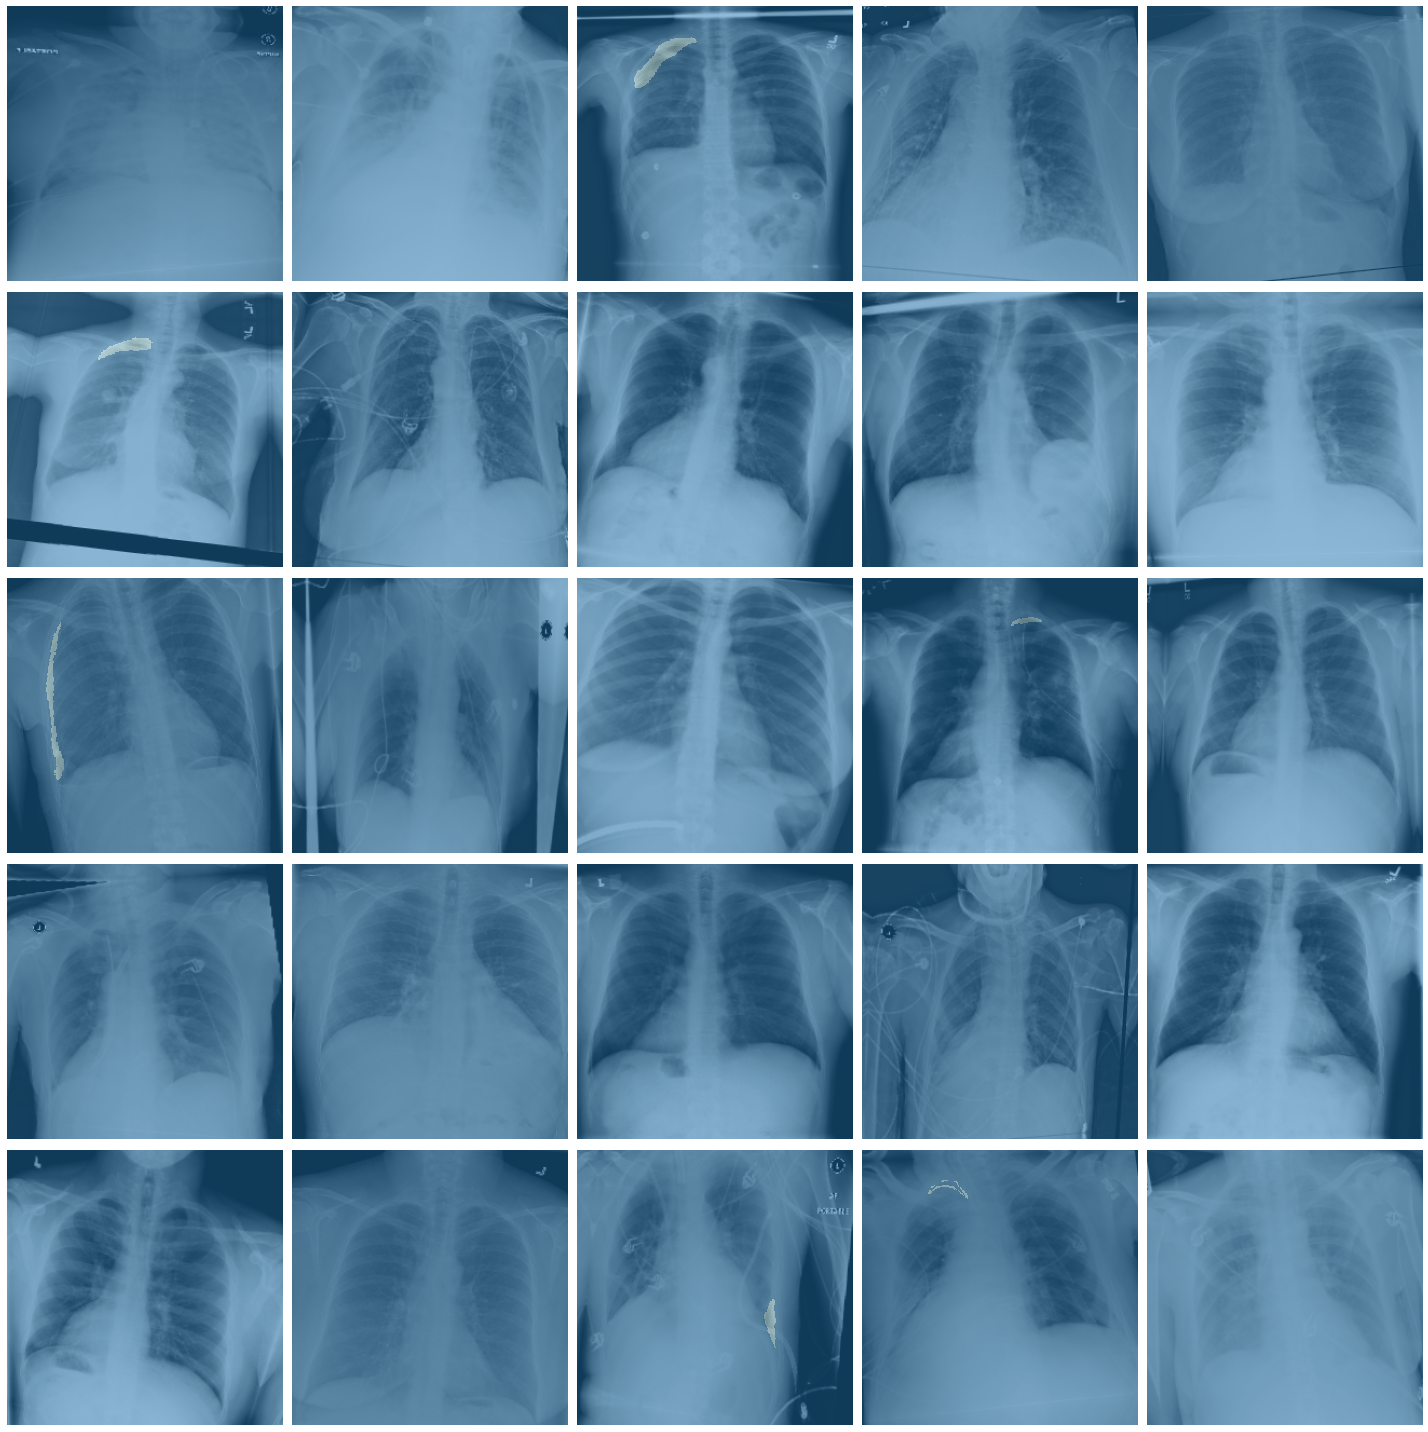

In [ ]:
data.show_batch()

In [ ]:
learn=unet_learner(data,models.resnet34,metrics=[dice])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,dice,time
0,0.019899,0.018407,0.783847,06:32
1,0.018360,0.015894,0.783847,06:24
2,0.014761,0.013803,0.783847,06:18
3,0.012299,0.011424,0.779409,06:17
4,0.011112,0.010563,0.772327,06:17


dice = intersection over union (IoU) in object detection = area of intersection / area of union


> The closer the dice metric gets to 1 the better it is for our segmentation performance. So according to the training results our segmentation method performs well.





epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


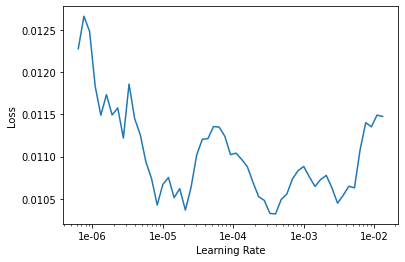

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.unfreeze()
lr=1e-3
learn.fit_one_cycle(5,slice(lr/30,lr))

epoch,train_loss,valid_loss,dice,time
0,0.011659,0.010854,0.755313,06:33
1,0.011869,0.009881,0.762555,06:32
2,0.010244,0.009002,0.784397,06:31
3,0.008827,0.008198,0.790436,06:31
4,0.007772,0.008098,0.791617,06:31


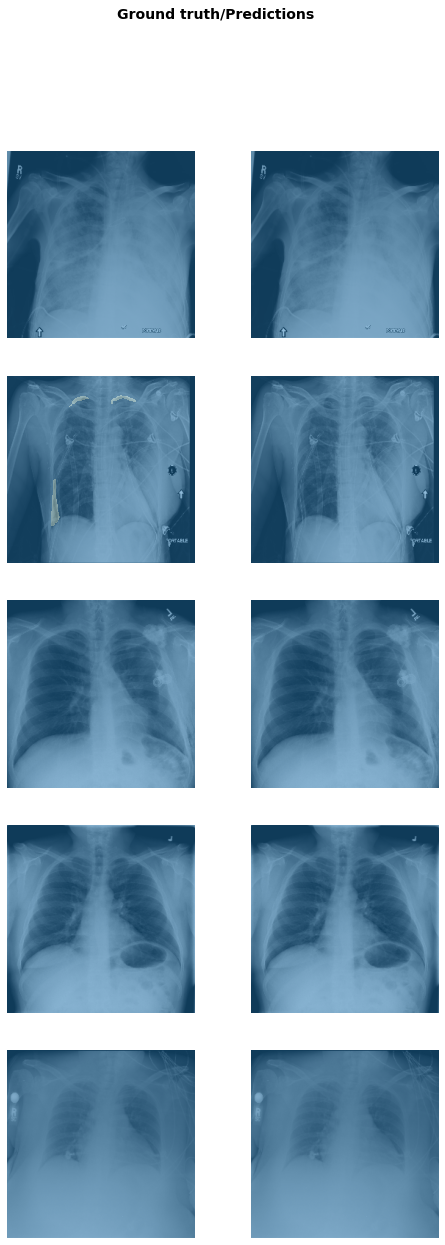

In [ ]:
learn.show_results()